## This notebook tests the implementation of PyTket library as a backend on OpenQAOA
* In OpenQAOA, PyTket is primarily used for circuit compilation, mapping and optimization of logically defined QAOA circuits to physical circuits implementable on devices with limited connectivity. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openqaoa.problems.problem import MaximumCut

In [3]:
maxcut_random = MaximumCut.random_instance(n_nodes=6, edge_probability=0.6)
maxcut_qubo = maxcut_random.get_qubo_problem()
maxcut_qubo.asdict()

{'terms': [[0, 1],
  [0, 5],
  [1, 2],
  [1, 4],
  [1, 5],
  [2, 3],
  [2, 5],
  [3, 5],
  [4, 5]],
 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'constant': 0,
 '_n': 6}

In [4]:
from openqaoa.utilities import X_mixer_hamiltonian
cost_hamiltonian = maxcut_qubo.hamiltonian
mixer_hamiltonian = X_mixer_hamiltonian(n_qubits=cost_hamiltonian.n_qubits)

In [5]:
from openqaoa.qaoa_parameters import QAOACircuitParams
circuit_params = QAOACircuitParams(cost_hamiltonian, mixer_hamiltonian, p=1)
circuit_params

Circuit Parameters:
	p: 1
	register: [0, 1, 2, 3, 4, 5]

Cost Hamiltonian:
	cost_qubits_singles: []
	cost_single_qubit_coeffs: []
	cost_qubits_pairs: [PauliOp(ZZ,(0, 1)), PauliOp(ZZ,(0, 5)), PauliOp(ZZ,(1, 2)), PauliOp(ZZ,(1, 4)), PauliOp(ZZ,(1, 5)), PauliOp(ZZ,(2, 3)), PauliOp(ZZ,(2, 5)), PauliOp(ZZ,(3, 5)), PauliOp(ZZ,(4, 5))]
	cost_pair_qubit_coeffs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Mixer Hamiltonian:
	mixer_qubits_singles: [PauliOp(X,(0,)), PauliOp(X,(1,)), PauliOp(X,(2,)), PauliOp(X,(3,)), PauliOp(X,(4,)), PauliOp(X,(5,))]
	mixer_single_qubit_coeffs: [-1, -1, -1, -1, -1, -1]
	mixer_qubits_pairs: []
	mixer_pair_qubit_coeffs: []

In [6]:
from openqaoa.qaoa_parameters import create_qaoa_variational_params

In [7]:
params = create_qaoa_variational_params(circuit_params, params_type='standard', init_type='rand')
params

Standard Parameterisation:
	p: 1
Variational Parameters:
	betas: [0.6383998]
	gammas: [2.42353516]

In [8]:
from openqaoa.devices import create_device, DevicePyTket
ibmq_qpu_credentials ={
    "api_token": "34edbe2020d32da16c0b6a743d462b11a189cbe4e8c000de677fb2a6ca2e0d527c64d14fb3de6c07a6ae3f6897aa5b05a21f948f71cd3f60453aa7bdb29c3410",
    "hub": "ibm-q-startup",
    "group": "entropica-labs",
    "project": "benchmarking-tes"
}
qiskit_device = create_device(location='ibmq', name='ibmq_jakarta', **ibmq_qpu_credentials)

In [9]:
from openqaoa.backends import QAOAPyTketBackend, QAOAQiskitQPUBackend

In [10]:
backend = QAOAPyTketBackend(circuit_params, qiskit_device, n_shots=1000, prepend_state=None, append_state=None, init_hadamard=True, cvar_alpha=1)

In [11]:
from pytket.circuit.display import render_circuit_jupyter
render_circuit_jupyter(backend.parametric_qaoa_circuit)

In [14]:
parametric_circuit = backend.parametric_qaoa_circuit

In [16]:
tket_backend = backend.device.backend_device

In [17]:
tket_backend.get_compiled_circuit?

Signature:
tket_backend.get_compiled_circuit(
    circuit: pytket._tket.circuit.Circuit,
    optimisation_level: int = 1,
) -> pytket._tket.circuit.Circuit
Docstring:
Return a single circuit compiled with default_compilation_pass. See
:py:meth:`Backend.get_compiled_circuits`.
File:      ~/opt/anaconda3/envs/oq/lib/python3.8/site-packages/pytket/backends/backend.py
Type:      method


In [21]:
compiled_circuit2 = tket_backend.get_compiled_circuit(parametric_circuit,optimisation_level=2)

In [22]:
compiled_circuit = backend.device.backend_device.get_compiled_circuit(backend.parametric_circuit)

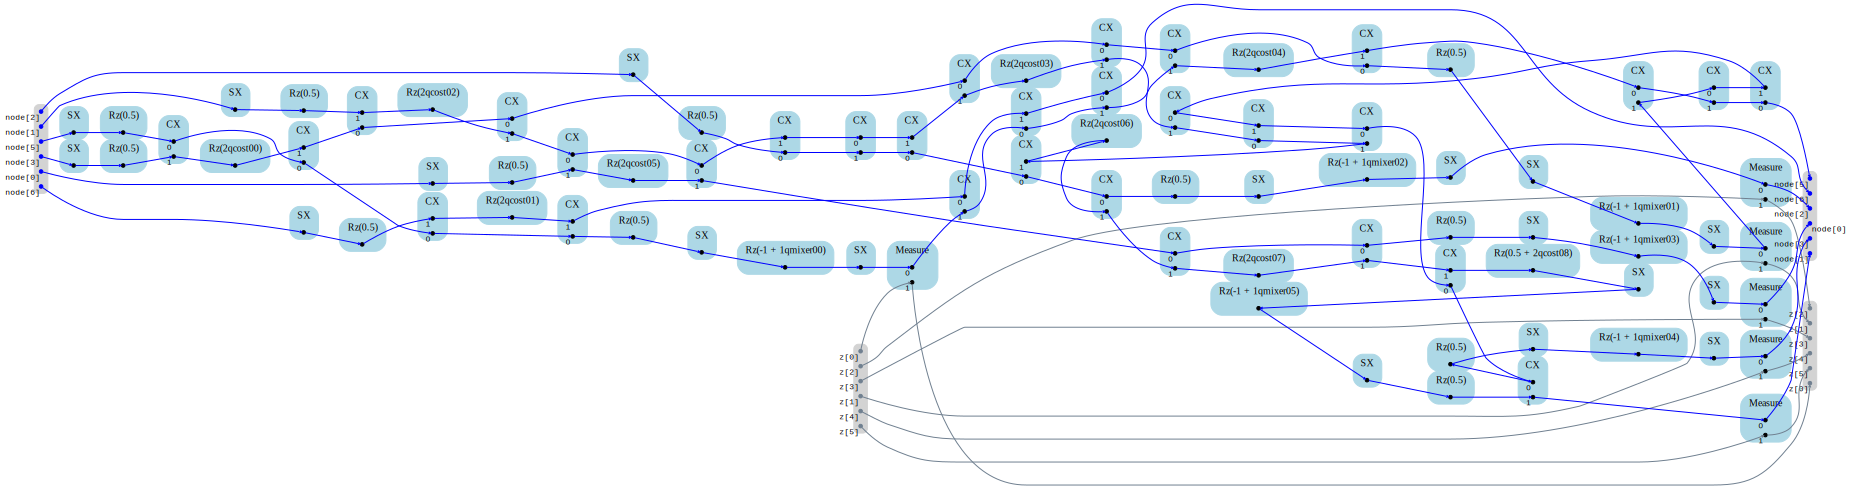

In [23]:
from pytket.utils import Graph
Graph(compiled_circuit).get_DAG()

In [72]:
render_circuit_jupyter(compiled_circuit)

In [42]:
backend_qis = QAOAQiskitQPUBackend(circuit_params, qiskit_device, n_shots=1000, prepend_state=None, append_state=None, init_hadamard=True, cvar_alpha=1)

In [19]:
from pytket.circuit import Circuit, OpType

In [23]:
ckt = Circuit(2)